In [1]:
#!pip install pandas
#!pip install catboost
#!pip install scikit_learn
#!pip install seaborn
#!pip install seaborn
#!pip install imblearn
#!pip install cPickle

In [2]:
#import required Libraries
# import libraries
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
import pickle
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import datetime as dt
import seaborn as sns
import scipy.stats as scistat
#from imblearn.over_sampling import SMOTE
import csv
import _pickle as cPickle
import sys
plt.style.use("ggplot")

# Data

## Read Data and take a look into it

In [3]:
#read data set and show the top 5 rows
data_df = pd.read_csv('new_fraud_prep.csv')
data_df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V24,V25,V26,V27,V28,Amount,Class,V29,V30,V31
0,0,0.0,NaN,-0.072781,NaN,NaN,-0.338321,0.462388,0.239599,0.098698,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,"4820 Sunrise Highway\nSayville, NY 11782\n(40....",NaN,Suffolk
1,1,0.0,1.191857,0.266151,NaN,NaN,0.060018,-0.082361,-0.078803,0.085102,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,"51 20 Northern Boulevard\nWoodside, NY 11377\n","JPMorgan Chase Bank, National Association",Nassau
2,2,1.0,-1.358354,-1.340163,NaN,NaN,-0.503198,1.800499,0.791461,0.247676,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,"103 Main Street\nCooperstown, NY 13326\n(42.70...",TD Bank N.A.,Erie
3,3,1.0,-0.966272,-0.185226,NaN,NaN,-0.010309,1.247203,0.237609,0.377436,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,NaN,Santander Bank,Ulster
4,4,2.0,-1.158233,0.877737,NaN,NaN,-0.407193,0.095921,0.592941,-0.270533,...,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,"2872 Broadway\nNew York, NY 10025\n(40.805224,...",Chemung Canal Trust Company,Oswego


In [4]:
data_df.set_index('Unnamed: 0', inplace=True)

In [5]:
data_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Wooow, it is super skewed

### Classes are imbalanced, and data huge. To prevent out of memory and biased classification, we use under sampling to have more balanced labeles.

#### First lets take care of data with Nulls

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284807 entries, 0 to 284806
Data columns (total 34 columns):
Time      284807 non-null float64
V1        240724 non-null float64
V2        280328 non-null float64
V3        135995 non-null float64
V4        14240 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26   

#### There are some nulls, lets take a look into it

 total count of data is 284807 and the number of Nulls per column is:


<BarContainer object of 34 artists>

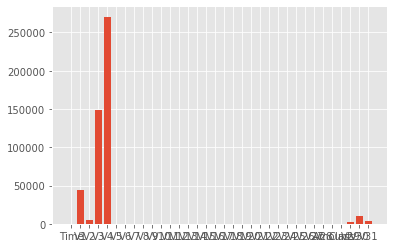

In [7]:
query = 'Nulls'
print(f" total count of data is {data_df.shape[0]} and the number of {query} per column is:")
col_with_nulls = data_df.isnull().sum()
plt.bar(col_with_nulls.index, col_with_nulls)

### Remove columns with more than half their value as Nan

In [8]:
col_with_nulls = col_with_nulls[col_with_nulls > len(col_with_nulls)/2]

In [9]:
data_df.drop(columns=col_with_nulls.index, inplace=True)

 total count of data is 284807 and the number of Nulls per column is:


<BarContainer object of 27 artists>

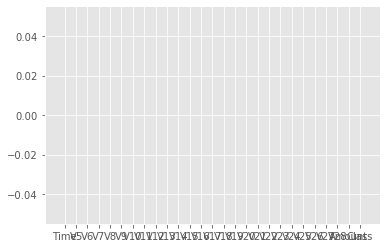

In [10]:
query = 'Nulls'
print(f" total count of data is {data_df.shape[0]} and the number of {query} per column is:")
col_with_nulls = data_df.isnull().sum()
plt.bar(col_with_nulls.index, col_with_nulls)

#### There is just one column with one Null value which we will replace, first lets take a look at it

In [11]:
col_with_nulls = col_with_nulls[col_with_nulls > 0]

In [12]:
col_with_nulls

Series([], dtype: int64)

### it is int so we replace it with -1

In [13]:
data_df.fillna(-1, inplace=True) #-1 will keep the information that it was null rather than replacing with zero

In [14]:
query = 'Nulls'
print(f" total count of data is {data_df.shape[0]} and the number of {query} per column is:")
total_nulls = data_df.isnull().sum().sum()
print('Total number of nulls in the data set is: ',total_nulls)

 total count of data is 284807 and the number of Nulls per column is:
Total number of nulls in the data set is:  0


In [15]:
data_df.head()

,Time,V5,V6,V7,V8,V9,V10,V11,V12,V13,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,0.0,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [16]:
# number of unique values per column
data_df_cols_nunique = data_df.nunique()
data_df_cols_nunique

Time      124592
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [17]:
#data_df['v_cat_2'].value_counts()[:20]

In [18]:
data_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [19]:
data_df.shape, 284315/492

((284807, 27), 577.8760162601626)

#### To create more balanced sample we remove some samples with install==0, class 0 is 577 times larger we reduce it to be just 20 times larger

In [20]:
data_train_old = data_df
labels_train_old = data_df['Class']
data_filter = np.random.randint(0, 30, data_df.shape[0])
data_filter = (1-labels_train_old) * data_filter.T==0
data_df = data_df[data_filter.T]
data_df.shape

(9914, 27)

In [21]:
data_df['Class'].value_counts()

0    9422
1     492
Name: Class, dtype: int64

### Checking the correlation matrix

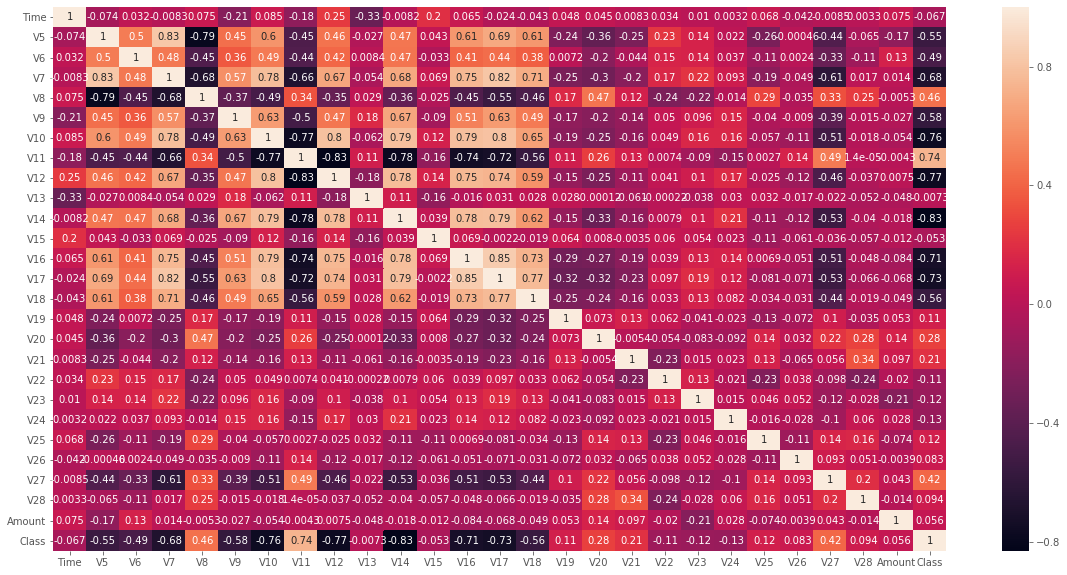

In [22]:
# plot heatmap of the correlation matrix
plt.figure(figsize = (20,10))
heatmap = sns.heatmap(data_df.head(1000).corr(), annot = True)

### Cheking Coefficient of Variation for each feature.

In [23]:
coef_var=scistat.variation(data_df.head(1000))
for i, col in enumerate(data_df.columns):
    print(col+" : ",coef_var[i])

Time :  0.544455013427778
V5 :  -4.1702887647072
V6 :  -8.90416013842992
V7 :  -3.897946525337148
V8 :  6.578044484034233
V9 :  18.09628827616181
V10 :  -3.6915632524172826
V11 :  2.174924902568038
V12 :  -2.110117607890206
V13 :  2.8992898962135647
V14 :  -7.753581887019882
V15 :  18.935758230312207
V16 :  -4.59306929329094
V17 :  -6.168157830676265
V18 :  -3.86209125105668
V19 :  -605.9306229184258
V20 :  8.014174391030608
V21 :  68.49746055379725
V22 :  -4.4460400085822345
V23 :  -15.298243214165351
V24 :  -24.76261432546811
V25 :  3.9969016177317696
V26 :  11.126950667623609
V27 :  5.433255718726514
V28 :  25.51316703816867
Amount :  2.218839596736991
Class :  3.1229294215596695


#### Some columns have coefficients larger than 1 which indicates higher std than mean

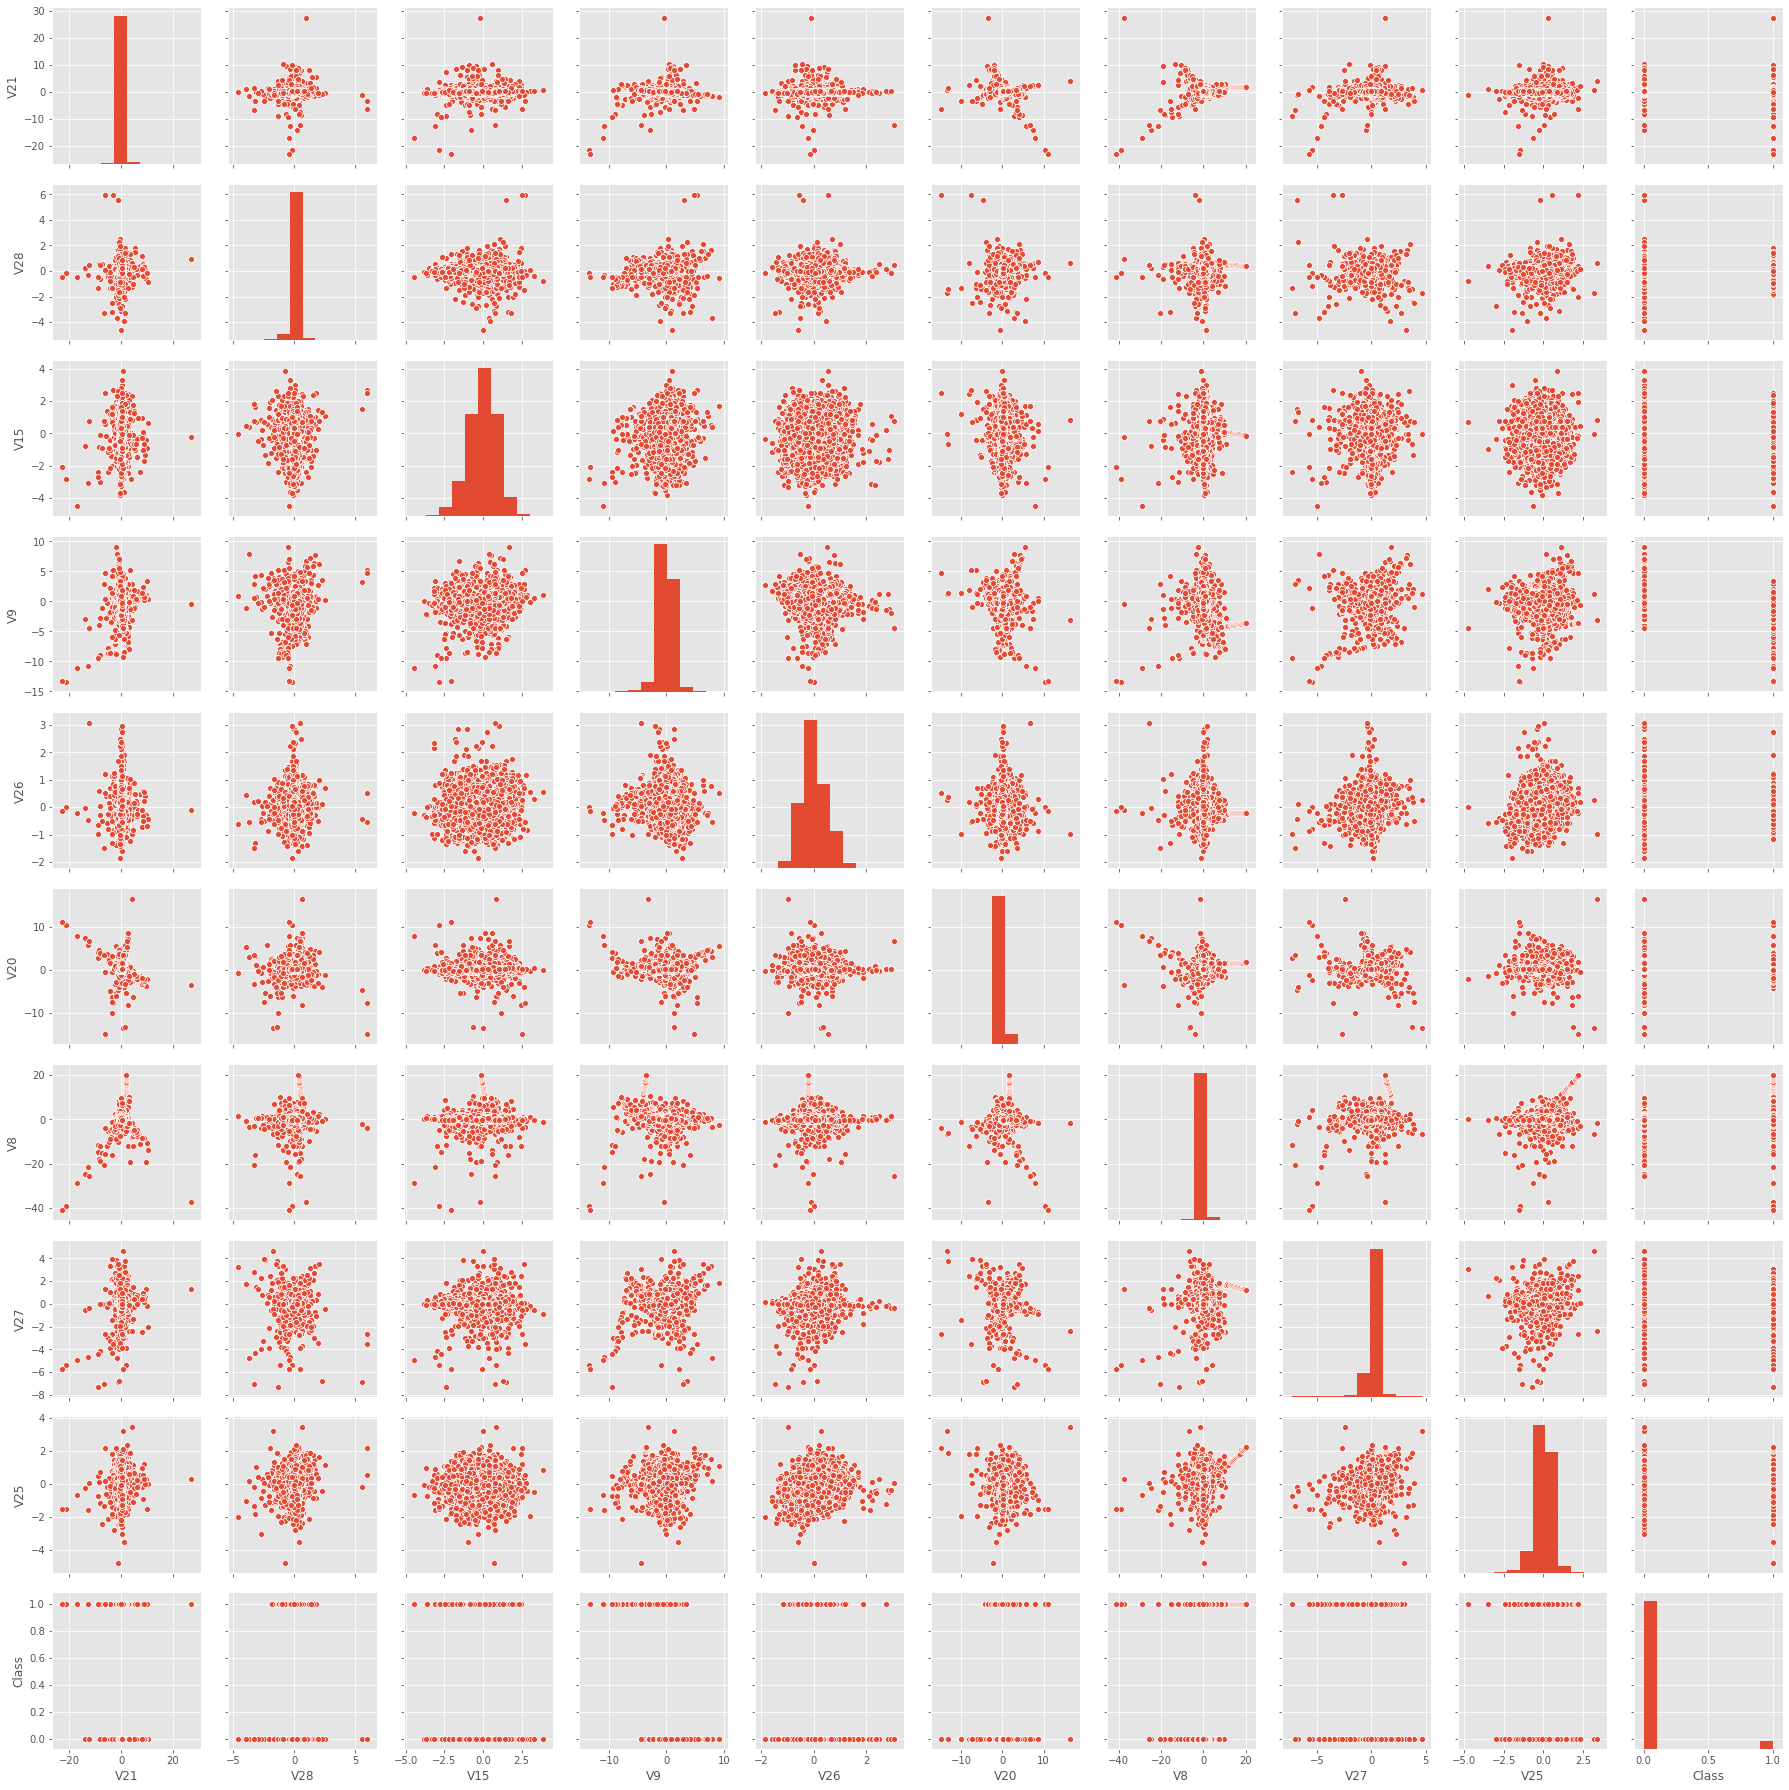

In [24]:
#lets plot it
cv=coef_var.argsort()[::-1][:10]  
cols=data_df.columns[cv]
sns.pairplot(data_df[cols])

## Compute pairwise correlation between target and other variables

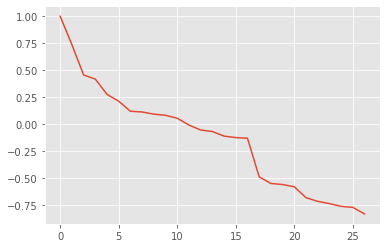

In [25]:
corr = data_df.head(1000).corr()
corr1=corr.loc['Class',:]

corr = corr.sort_values(by = 'Class', ascending= False)
plt.plot(corr['Class'].values, label="corr")
plt.show()

### Select Highly correlated values

In [26]:
threshold_corr = 0.2
corr_significant = corr["Class"].copy (deep =True)
corr_significant = corr_significant.loc[(corr_significant.values > threshold_corr) | \
                                       (corr_significant.values < -threshold_corr)]
print("Significant target variables are " + str(corr_significant.index[1:].values) )
print("Their correaltions are " + str( np.round(corr_significant[1:].values,2 ) ) )

Significant target variables are ['V11' 'V8' 'V27' 'V20' 'V21' 'V6' 'V5' 'V18' 'V9' 'V7' 'V16' 'V17' 'V10'
 'V12' 'V14']
Their correaltions are [ 0.74  0.46  0.42  0.28  0.21 -0.49 -0.55 -0.56 -0.58 -0.68 -0.71 -0.73
 -0.76 -0.77 -0.83]


## remove labels from data set

In [27]:
#label column target has no null, it is good to go so we just seperate features and labels
labels_train = data_df['Class']
data_train = data_df.drop(columns='Class')
data_train_old = data_train_old.drop(columns='Class')

In [28]:
data_train.min()

Time      35.000000
V5       -22.105532
V6       -17.927274
V7       -43.557242
V8       -41.044261
V9       -13.434066
V10      -24.588262
V11       -3.881222
V12      -18.683715
V13       -3.396489
V14      -19.214325
V15       -4.498945
V16      -14.129855
V17      -25.162799
V18       -9.498746
V19       -4.051538
V20      -14.954782
V21      -22.797604
V22       -8.887017
V23      -19.254328
V24       -2.454716
V25       -4.781606
V26       -1.855355
V27       -7.263482
V28       -4.600980
Amount     0.000000
dtype: float64

In [29]:
from sklearn.preprocessing import StandardScaler,Normalizer
# Standardizing the data
#StdScal = StandardScaler(0,1)
data_train = Normalizer().fit_transform(data_train)
data_train_old = Normalizer().transform(data_train_old)
#data_train = StdScal.fit_transform(data_train)

## Dimensionality Reduction

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

#import metrics
from sklearn.metrics import mean_squared_error as MSE,  r2_score, accuracy_score, confusion_matrix


## Feature Selection

In [31]:
#data_train = data_train - data_train.min()
#data_train_old = data_train_old - data_train_old.min()
#data_train.min()

In [32]:
#transformer = GenericUnivariateSelect(chi2, 'k_best', param=20)

In [33]:
#data_train.min()

In [34]:
#data_train.shape, data_train_old.shape

In [35]:
#data_train = transformer.fit_transform(data_train, labels_train)
#data_train_old = transformer.transform(data_train_old)

### Next cross validation

In [36]:
from xgboost import XGBClassifier

In [37]:
score=[]
tot_mse=[]
tot_score=[]
components=[1,2,5,8,10,12,15]


for comp in components:
    pca = PCA(n_components=comp)
    data_train_PCA = pca.fit_transform(data_train)
    n_splits=3
    MSE1= []
  
    for i in range(n_splits):
        x_train, x_val, y_train, y_val  = train_test_split(data_train_PCA, labels_train.values, test_size = .3, random_state=i)
        p_model=XGBClassifier(n_estimators=20)
        p_model = p_model.fit(x_train,y_train)
        y_pred = p_model.predict(x_val)
        mse = accuracy_score(y_val, y_pred)
        MSE1.append(mse)

        
        scores = cross_val_score(p_model, x_val, y_val, cv=5)
        score.append(np.mean(scores))
        
    tot_mse.append(np.mean(MSE1))
    tot_score.append(np.mean(score))

In [38]:
pca_res = pd.DataFrame({"Number of Components":components,"Validation MSE":tot_mse,"Score":tot_score})
pca_res

,Number of Components,Validation MSE,Score
0,1,0.951036,0.951597
1,2,0.957423,0.953894
2,5,0.962353,0.956377
3,8,0.988908,0.964174
4,10,0.989356,0.968807
5,12,0.988908,0.971839
6,15,0.988908,0.974086


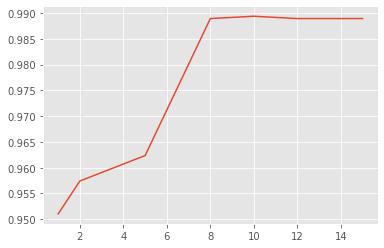

In [39]:
plt.plot(pca_res['Number of Components'],pca_res['Validation MSE'] )

#### n=8 gives a good elbow point

In [40]:
#PCA to apply Principal component analysis and create independent but expressive columns
n_cols = 8
pca = PCA(n_components=n_cols)
cols_PCA = [ 'principal component '+str(i) for i in range(n_cols)]

In [41]:
#fir PCA
data_train_PCA = pca.fit_transform(data_train)
data_train_PCA_old = pca.transform(data_train_old)
print(f'shape of data train changed from{data_train.shape} to {data_train_PCA.shape}')

shape of data train changed from(9914, 26) to (9914, 8)


In [42]:
#checking the PCA performance
cum_variance_explained = pca.explained_variance_ratio_
#print(np.round(pca.explained_variance_ratio_,2))
print("We explain " + str( np.round(pca.explained_variance_ratio_.sum(),2 ) ) )

We explain 1.0


## Oversampling the smaller class to have a better balance between classes

Counter({0: 9422, 1: 492})


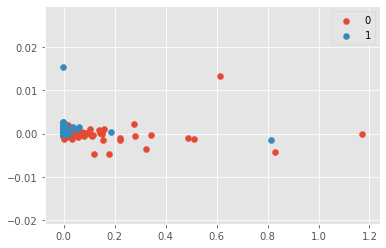

In [43]:
# summarize class distribution
y = labels_train
X = data_train_PCA
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 6], label=str(label))
plt.legend()
plt.show()

In [44]:
#it takes too much memories instead we will under sample it
from imblearn.over_sampling import SVMSMOTE
# summarize class distribution
print("Before Under Sampling" , Counter(y))
# define undersample strategy
over_sampler = SVMSMOTE()
# fit and apply the transform
X, y = over_sampler.fit_resample(X, y)
# summarize class distribution
print("After Under Sampling" ,Counter(y))

Using TensorFlow backend.


Before Under Sampling Counter({0: 9422, 1: 492})
After Under Sampling Counter({0: 9422, 1: 9422})


Counter({0: 9422, 1: 9422})


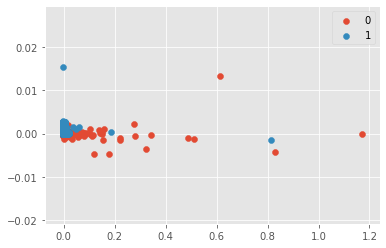

In [45]:
#lets check our classes again
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 6], label=str(label))
plt.legend()
plt.show()

## Test and Train split

In [46]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

## models pipeline 

In [47]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier as Ridge, RidgeClassifierCV as RidgeCV

#import metrics
from sklearn.metrics import confusion_matrix as MSE,  r2_score

In [48]:
l_model=PassiveAggressiveClassifier()
l_model.fit(X_train,y_train)

y_pred=l_model.predict(X_test)
mean_squared_error = MSE(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[   0 2809]
 [   0 2845]]
R2 score on Test set : -0.987346221441125


In [49]:
#check on train data set for overfitting
y_pred=l_model.predict(data_train_PCA_old)
mean_squared_error = MSE(labels_train_old,y_pred)
print("Mean squared error on Train set :\n",mean_squared_error)
r2_score_error = r2_score(labels_train_old,y_pred)
print("R2 score on Train set :",r2_score_error)

Mean squared error on Train set :
 [[    18 284297]
 [     0    492]]
R2 score on Train set : -577.8393675842477


#### Test and train performance are very close, but both performing bad

### Add results of the model as extra feature

In [50]:
X.shape

(18844, 8)

In [51]:
#concatenate the results to it
X = np.concatenate((X,l_model.predict(X).reshape(-1,1)), axis=1)
data_train_PCA_old = np.concatenate((data_train_PCA_old,l_model.predict(data_train_PCA_old).reshape(-1,1)), axis=1)
X.shape

(18844, 9)

In [52]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = .3, random_state=12)

In [53]:
#setup hyper parameters
model_xgb = XGBClassifier(learning_rate=0.05, max_depth=8, min_child_weight=1)

In [54]:
#train XGboost
model_xgb.fit(X_train, y_train, eval_set= [(X_test, y_test)], early_stopping_rounds=10,  verbose=1)

[0]	validation_0-error:0.025646
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.024584
[2]	validation_0-error:0.024231
[3]	validation_0-error:0.025646
[4]	validation_0-error:0.024584
[5]	validation_0-error:0.024584
[6]	validation_0-error:0.024761
[7]	validation_0-error:0.024054
[8]	validation_0-error:0.024231
[9]	validation_0-error:0.023877
[10]	validation_0-error:0.023523
[11]	validation_0-error:0.023346
[12]	validation_0-error:0.023346
[13]	validation_0-error:0.022639
[14]	validation_0-error:0.023523
[15]	validation_0-error:0.0237
[16]	validation_0-error:0.022639
[17]	validation_0-error:0.023169
[18]	validation_0-error:0.022816
[19]	validation_0-error:0.022462
[20]	validation_0-error:0.022108
[21]	validation_0-error:0.021401
[22]	validation_0-error:0.020693
[23]	validation_0-error:0.020516
[24]	validation_0-error:0.019986
[25]	validation_0-error:0.020163
[26]	validation_0-error:0.019632
[27]	validation_0-error:0.019278
[28]	validation_0-erro

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [55]:
#predict test data
y_pred=model_xgb.predict(X_test)
mean_squared_error = MSE(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[2810   29]
 [  36 2779]]
R2 score on Test set : 0.9540140281551618


In [56]:
#check on train data set for overfitting
y_pred=model_xgb.predict(data_train_PCA_old)
mean_squared_error = MSE(labels_train_old,y_pred)
print("Mean squared error on Train set :\n",mean_squared_error)
r2_score_error = r2_score(labels_train_old,y_pred)
print("R2 score on Train set :",r2_score_error)

Mean squared error on Train set :
 [[281928   2387]
 [    42    450]]
R2 score on Train set : -3.9455352109313067


#### Now looks better

In [57]:
#concatenate the results to it
X = np.concatenate((X,model_xgb.predict_proba(X)[:,:1].reshape(-1,1)), axis=1)
data_train_PCA_old = np.concatenate((data_train_PCA_old,model_xgb.predict_proba(data_train_PCA_old)[:,:1].reshape(-1,1)), axis=1)
X.shape

(18844, 10)

In [58]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

## Catboost Model

In [59]:
#preparing data sets and labels for catboost
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=[])

test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=[])

In [60]:
#parameter setting for catboost
model_ctb = CatBoostClassifier(depth=10, iterations= 1000)

In [61]:
# Fit model
model_ctb.fit(train_dataset,eval_set=test_dataset,early_stopping_rounds=10, plot=True)

Learning rate set to 0.1023
0:	learn: 0.4583729	test: 0.4589903	best: 0.4589903 (0)	total: 170ms	remaining: 2m 50s
1:	learn: 0.2991774	test: 0.3002616	best: 0.3002616 (1)	total: 286ms	remaining: 2m 22s
2:	learn: 0.1989446	test: 0.2002169	best: 0.2002169 (2)	total: 419ms	remaining: 2m 19s
3:	learn: 0.1382445	test: 0.1397488	best: 0.1397488 (3)	total: 551ms	remaining: 2m 17s
4:	learn: 0.1035914	test: 0.1059688	best: 0.1059688 (4)	total: 707ms	remaining: 2m 20s
5:	learn: 0.0794990	test: 0.0820021	best: 0.0820021 (5)	total: 882ms	remaining: 2m 26s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

6:	learn: 0.0611253	test: 0.0639734	best: 0.0639734 (6)	total: 1.07s	remaining: 2m 31s
7:	learn: 0.0514670	test: 0.0544549	best: 0.0544549 (7)	total: 1.08s	remaining: 2m 14s
8:	learn: 0.0424339	test: 0.0464973	best: 0.0464973 (8)	total: 1.23s	remaining: 2m 15s
9:	learn: 0.0358316	test: 0.0404931	best: 0.0404931 (9)	total: 1.35s	remaining: 2m 13s
10:	learn: 0.0313140	test: 0.0365336	best: 0.0365336 (10)	total: 1.49s	remaining: 2m 13s
11:	learn: 0.0275038	test: 0.0333909	best: 0.0333909 (11)	total: 1.61s	remaining: 2m 12s
12:	learn: 0.0249276	test: 0.0313398	best: 0.0313398 (12)	total: 1.72s	remaining: 2m 10s
13:	learn: 0.0229081	test: 0.0297519	best: 0.0297519 (13)	total: 1.82s	remaining: 2m 8s
14:	learn: 0.0211345	test: 0.0285549	best: 0.0285549 (14)	total: 1.93s	remaining: 2m 6s
15:	learn: 0.0199489	test: 0.0277946	best: 0.0277946 (15)	total: 2.08s	remaining: 2m 7s
16:	learn: 0.0188663	test: 0.0268754	best: 0.0268754 (16)	total: 2.19s	remaining: 2m 6s
17:	learn: 0.0179289	test: 0.0262

In [62]:
# Get predicted classes
y_pred = model_ctb.predict(test_dataset)
mean_squared_error = MSE(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[2788   21]
 [  15 2830]]
R2 score on Test set : 0.9745302727049198


In [63]:
#check on train data set for overfitting
y_pred=model_ctb.predict(data_train_PCA_old)
mean_squared_error = MSE(labels_train_old,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(labels_train_old,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[281582   2733]
 [    18    474]]
R2 score on Test set : -4.601139302293959


In [64]:
#concatenate the results to it
X = np.concatenate((X,model_ctb.predict_proba(X)[:,:1].reshape(-1,1)), axis=1)
data_train_PCA_old = np.concatenate((data_train_PCA_old,model_ctb.predict_proba(data_train_PCA_old)[:,:1].reshape(-1,1)), axis=1)
X.shape

(18844, 11)

In [65]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

## Ridge Model

In [66]:
#with Ridge Model
Ridge_model = Ridge(alpha = 0.02)
Ridge_model.fit(X_train, y_train)

RidgeClassifier(alpha=0.02, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [67]:
#predict test data
y_pred=Ridge_model.predict(X_test)
mean_squared_error = MSE(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[2788   21]
 [  13 2832]]
R2 score on Test set : 0.9759452575546465


In [68]:
#predict test data
y_pred=Ridge_model.predict(data_train_PCA_old)
mean_squared_error = MSE(labels_train_old,y_pred)
print("Mean squared Train on Test set :\n",mean_squared_error)
r2_score_error = r2_score(labels_train_old,y_pred)
print("R2 score on Train set :",r2_score_error)

Mean squared Train on Test set :
 [[281403   2912]
 [    13    479]]
R2 score on Train set : -4.955409836135888


In [69]:
#with Ridge Model
Ridge_model = RidgeCV()
Ridge_model.fit(X_train, y_train)

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=None,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False)

In [70]:
#predict test data
y_pred=Ridge_model.predict(X_test)
mean_squared_error = MSE(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[2788   21]
 [  13 2832]]
R2 score on Test set : 0.9759452575546465


In [71]:
#predict test data
y_pred=Ridge_model.predict(data_train_PCA_old)
mean_squared_error = MSE(labels_train_old,y_pred)
print("Mean squared Train on Test set :\n",mean_squared_error)
r2_score_error = r2_score(labels_train_old,y_pred)
print("R2 score on Train set :",r2_score_error)

Mean squared Train on Test set :
 [[281405   2910]
 [    13    479]]
R2 score on Train set : -4.951337761034257


In [72]:
#concatenate the results to it
X = np.concatenate((X,Ridge_model.predict(X).reshape(-1,1)), axis=1)
data_train_PCA_old = np.concatenate((data_train_PCA_old,Ridge_model.predict(data_train_PCA_old).reshape(-1,1)), axis=1)
X.shape

(18844, 12)

## Deep Neural Network Model

In [73]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [74]:
er = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
rl = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, mode='auto')

### Neural Networks will help up to extract  nonlinear interdependencies

In [75]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X, y.values, test_size = .3, random_state=42)

In [76]:
def AUC_model(loss_b):
    model = Sequential()
    model.add(
        Dense(
            64,
            input_dim=X_train.shape[1],
            kernel_initializer='glorot_normal',
            ))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid',
            kernel_initializer='glorot_normal'))

    # Compile model
    model.compile(optimizer='Adam', metrics = ['AUC'], loss=loss_b)
    print(model.summary())

    return model

In [77]:
#Using KL-Divergence as Loss helps us to find the most probable False answers
Deep_Model = AUC_model('kullback_leibler_divergence')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,153
Trainable params: 1,025
Non-trainable params: 128
_________________________________________________________________
None


In [78]:
history_AUC_PCA = Deep_Model.fit(X_train, y_train, validation_data= (X_test, y_test), 
                                 epochs=2000, batch_size=1000, callbacks=[er,rl], verbose=2)

Train on 13190 samples, validate on 5654 samples
Epoch 1/2000
13190/13190 - 3s - loss: 0.3022 - AUC: 0.7129 - val_loss: 0.4130 - val_AUC: 0.9982
Epoch 2/2000
13190/13190 - 0s - loss: 0.1153 - AUC: 0.9840 - val_loss: 0.3323 - val_AUC: 0.9993
Epoch 3/2000
13190/13190 - 0s - loss: 0.0419 - AUC: 0.9991 - val_loss: 0.2750 - val_AUC: 0.9991
Epoch 4/2000
13190/13190 - 0s - loss: 0.0227 - AUC: 0.9990 - val_loss: 0.2345 - val_AUC: 0.9992
Epoch 5/2000
13190/13190 - 0s - loss: 0.0154 - AUC: 0.9993 - val_loss: 0.2024 - val_AUC: 0.9991
Epoch 6/2000
13190/13190 - 0s - loss: 0.0113 - AUC: 0.9993 - val_loss: 0.1774 - val_AUC: 0.9993
Epoch 7/2000
13190/13190 - 0s - loss: 0.0096 - AUC: 0.9995 - val_loss: 0.1571 - val_AUC: 0.9994
Epoch 8/2000
13190/13190 - 0s - loss: 0.0089 - AUC: 0.9994 - val_loss: 0.1387 - val_AUC: 0.9991
Epoch 9/2000
13190/13190 - 0s - loss: 0.0086 - AUC: 0.9994 - val_loss: 0.1221 - val_AUC: 0.9991
Epoch 10/2000
13190/13190 - 0s - loss: 0.0074 - AUC: 0.9995 - val_loss: 0.1066 - val_AU

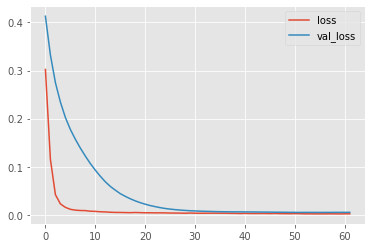

In [79]:
plt.plot(history_AUC_PCA.history['loss'], label= 'loss')
plt.plot(history_AUC_PCA.history['val_loss'], label= 'val_loss')
plt.legend()
plt.show()

In [80]:
# Get predicted classes
pred_test = Deep_Model.predict(X_test)
pred_val_AUC_PCA = np.round(pred_test,0)
    
acc_AUC_PCA = accuracy_score(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

0.9932790944464096


In [81]:
acc_AUC_PCA = confusion_matrix(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

[[2782   11]
 [  27 2834]]


In [82]:
#Using mse now will help to extract nonlinear dependencies with a better focus on positive answers
Deep_Model_1 = AUC_model('binary_crossentropy')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                832       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,153
Trainable params: 1,025
Non-trainable params: 128
_________________________________________________________________
None


In [83]:
history_AUC_PCA = Deep_Model_1.fit(X_train, y_train, validation_data= (X_test, y_test), 
                                 epochs=2000, batch_size=1000, callbacks=[er,rl], verbose=2)

Train on 13190 samples, validate on 5654 samples
Epoch 1/2000
13190/13190 - 2s - loss: 0.1188 - AUC: 0.9967 - val_loss: 0.4781 - val_AUC: 0.9991
Epoch 2/2000
13190/13190 - 0s - loss: 0.0328 - AUC: 0.9992 - val_loss: 0.4133 - val_AUC: 0.9993
Epoch 3/2000
13190/13190 - 0s - loss: 0.0162 - AUC: 0.9997 - val_loss: 0.3733 - val_AUC: 0.9991
Epoch 4/2000
13190/13190 - 0s - loss: 0.0130 - AUC: 0.9996 - val_loss: 0.3427 - val_AUC: 0.9993
Epoch 5/2000
13190/13190 - 0s - loss: 0.0103 - AUC: 0.9995 - val_loss: 0.3133 - val_AUC: 0.9994
Epoch 6/2000
13190/13190 - 0s - loss: 0.0088 - AUC: 0.9997 - val_loss: 0.2858 - val_AUC: 0.9992
Epoch 7/2000
13190/13190 - 0s - loss: 0.0088 - AUC: 0.9995 - val_loss: 0.2615 - val_AUC: 0.9990
Epoch 8/2000
13190/13190 - 0s - loss: 0.0081 - AUC: 0.9995 - val_loss: 0.2391 - val_AUC: 0.9990
Epoch 9/2000
13190/13190 - 0s - loss: 0.0072 - AUC: 0.9996 - val_loss: 0.2180 - val_AUC: 0.9994
Epoch 10/2000
13190/13190 - 0s - loss: 0.0068 - AUC: 0.9996 - val_loss: 0.1976 - val_AU

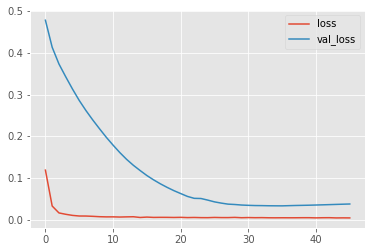

In [84]:
plt.plot(history_AUC_PCA.history['loss'], label= 'loss')
plt.plot(history_AUC_PCA.history['val_loss'], label= 'val_loss')
plt.legend()
plt.show()

In [85]:
# Get predicted classes
pred_test = Deep_Model_1.predict(X_test)
pred_val_AUC_PCA = np.round(pred_test,0)
    
acc_AUC_PCA = accuracy_score(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

0.9939865581888928


In [86]:
acc_AUC_PCA = confusion_matrix(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

[[2788   13]
 [  21 2832]]


In [87]:
#Using mse now will help to extract nonlinear dependencies with a better focus on positive answers
Deep_Model_2 = AUC_model('mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                832       
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,153
Trainable params: 1,025
Non-trainable params: 128
_________________________________________________________________
None


In [88]:
history_AUC_PCA = Deep_Model_2.fit(X_train, y_train, validation_data= (X_test, y_test), 
                                 epochs=2000, batch_size=1000, callbacks=[er,rl], verbose=2)

Train on 13190 samples, validate on 5654 samples
Epoch 1/2000
13190/13190 - 2s - loss: 0.1947 - AUC: 0.7770 - val_loss: 0.2283 - val_AUC: 0.9986
Epoch 2/2000
13190/13190 - 0s - loss: 0.0558 - AUC: 0.9969 - val_loss: 0.2002 - val_AUC: 0.9991
Epoch 3/2000
13190/13190 - 0s - loss: 0.0223 - AUC: 0.9993 - val_loss: 0.1791 - val_AUC: 0.9993
Epoch 4/2000
13190/13190 - 0s - loss: 0.0087 - AUC: 0.9996 - val_loss: 0.1632 - val_AUC: 0.9991
Epoch 5/2000
13190/13190 - 0s - loss: 0.0054 - AUC: 0.9995 - val_loss: 0.1531 - val_AUC: 0.9992
Epoch 6/2000
13190/13190 - 0s - loss: 0.0045 - AUC: 0.9997 - val_loss: 0.1440 - val_AUC: 0.9990
Epoch 7/2000
13190/13190 - 0s - loss: 0.0040 - AUC: 0.9993 - val_loss: 0.1353 - val_AUC: 0.9990
Epoch 8/2000
13190/13190 - 0s - loss: 0.0038 - AUC: 0.9996 - val_loss: 0.1264 - val_AUC: 0.9994
Epoch 9/2000
13190/13190 - 0s - loss: 0.0035 - AUC: 0.9995 - val_loss: 0.1176 - val_AUC: 0.9988
Epoch 10/2000
13190/13190 - 0s - loss: 0.0030 - AUC: 0.9996 - val_loss: 0.1083 - val_AU

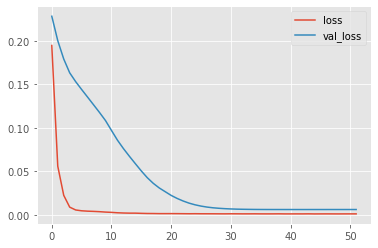

In [89]:
plt.plot(history_AUC_PCA.history['loss'], label= 'loss')
plt.plot(history_AUC_PCA.history['val_loss'], label= 'val_loss')
plt.legend()
plt.show()

In [90]:
# Get predicted classes
pred_test = Deep_Model_2.predict(X_test)
pred_val_AUC_PCA = np.round(pred_test,0)
    
acc_AUC_PCA = accuracy_score(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

0.9939865581888928


In [91]:
#check confusion_matrix for balance
acc_AUC_PCA = confusion_matrix(pred_val_AUC_PCA, y_test)
print(acc_AUC_PCA)

[[2788   13]
 [  21 2832]]


#### Data is too small for Deep Networks to learn, even with no deep layer it can't get enough data

# Ensemble the final model

In [92]:
X_new = np.concatenate((X, Deep_Model.predict(X)), axis=1)
X_new = np.concatenate((X_new, Deep_Model_1.predict(X)), axis=1)
X_new = np.concatenate((X_new, Deep_Model_2.predict(X)), axis=1)

In [93]:
data_train_PCA_new = np.concatenate((data_train_PCA_old, Deep_Model.predict(data_train_PCA_old)), axis=1)
data_train_PCA_new = np.concatenate((data_train_PCA_new, Deep_Model_1.predict(data_train_PCA_old)), axis=1)
data_train_PCA_new = np.concatenate((data_train_PCA_new, Deep_Model_2.predict(data_train_PCA_old)), axis=1)

In [94]:
#split data into test and train data sets
X_train,X_test,y_train, y_test = train_test_split(X_new, y.values, test_size = .3, random_state=42)

In [95]:
#preparing data sets and labels for catboost
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=[])

test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=[])

In [96]:
#parameter setting for catboost
model_ctb = CatBoostClassifier(depth=6, iterations= 1000)

In [97]:
# Fit model
model_ctb.fit(train_dataset,eval_set=test_dataset,early_stopping_rounds=20, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.1023
0:	learn: 0.3977053	test: 0.4008332	best: 0.4008332 (0)	total: 15ms	remaining: 15s
1:	learn: 0.2342150	test: 0.2404528	best: 0.2404528 (1)	total: 29.2ms	remaining: 14.6s
2:	learn: 0.1382302	test: 0.1475827	best: 0.1475827 (2)	total: 47.3ms	remaining: 15.7s
3:	learn: 0.0861466	test: 0.0978259	best: 0.0978259 (3)	total: 58.3ms	remaining: 14.5s
4:	learn: 0.0538348	test: 0.0669224	best: 0.0669224 (4)	total: 69.7ms	remaining: 13.9s
5:	learn: 0.0350022	test: 0.0497838	best: 0.0497838 (5)	total: 95.5ms	remaining: 15.8s
6:	learn: 0.0217647	test: 0.0382161	best: 0.0382161 (6)	total: 111ms	remaining: 15.8s
7:	learn: 0.0146289	test: 0.0326179	best: 0.0326179 (7)	total: 134ms	remaining: 16.7s
8:	learn: 0.0103003	test: 0.0296616	best: 0.0296616 (8)	total: 148ms	remaining: 16.3s
9:	learn: 0.0079445	test: 0.0288904	best: 0.0288904 (9)	total: 166ms	remaining: 16.4s
10:	learn: 0.0061780	test: 0.0280162	best: 0.0280162 (10)	total: 184ms	remaining: 16.6s
11:	learn: 0.0051008	t

In [98]:
y_pred = model_ctb.predict(test_dataset)
y_pred

array([1., 0., 1., ..., 1., 0., 0.])

In [99]:
# Get predicted classes
y_pred = model_ctb.predict(test_dataset)
mean_squared_error = confusion_matrix(y_test,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_test,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[2788   21]
 [  13 2832]]
R2 score on Test set : 0.9759452575546465


In [100]:
#check on train data set for overfitting
y_pred=model_ctb.predict(X_train)
mean_squared_error = MSE(y_train,y_pred)
print("Mean squared error on Test set :\n",mean_squared_error)
r2_score_error = r2_score(y_train,y_pred)
print("R2 score on Test set :",r2_score_error)

Mean squared error on Test set :
 [[6611    2]
 [   5 6572]]
R2 score on Test set : 0.9978771638679357


In [101]:
#check on train data set for overfitting
y_pred=model_ctb.predict(data_train_PCA_new)
mean_squared_error = MSE( labels_train_old.values,y_pred)
print("Mean squared error on full data set :\n",mean_squared_error)
r2_score_error = r2_score( labels_train_old.values,y_pred)
print("R2 score on full data set :",r2_score_error)

Mean squared error on full data set :
 [[281405   2910]
 [    11    481]]
R2 score on full data set : -4.947265685932625


# Probabilistic Confidence 

In [105]:
#Get confidence of the model via probability
#y_pred_proba=model_ctb.predict_proba(data_train_PCA_new)
print(f'confidence of the model ranges from {np.round(y_pred_proba.min(), 4)} to {np.round(y_pred_proba.max(), 4)}')

confidence of the model ranges from 0.0013 to 0.9987


### Lets take a more detailed look at the result distribution  and define the result based on confidence intevals

In [133]:
def Confident_classifier(prediction_prob, y, threshold):
    filt = prediction_prob[:,1] >= threshold
    print(f'With threshold as {np.round(threshold,4)} we have')
    conf_pred = np.array(filt)
    cm = confusion_matrix( y, conf_pred )

    positiveAccuracy = cm[1,1]/(cm[0,1]+ cm[1,1])
    print("Positive Accuracy is: ", positiveAccuracy, "\n")
    print(cm)
    negativeAccuracy = cm[0,0]/(cm[0,0]+ cm[1,0])
    print("Negative Accuracy is: ", negativeAccuracy)
    print('################################################################################')

In [130]:
y_pred_proba = model_ctb.predict_proba(data_train_PCA_new)

In [134]:
for threshod in np.linspace(0.99, y_pred_proba.max(), 20):
    Confident_classifier(y_pred_proba, labels_train_old.values,threshod)

With threshold as 0.99 we have
Positive Accuracy is:  0.2532726237905521 

[[283003   1312]
 [    47    445]]
Negative Accuracy is:  0.9998339515986575
################################################################################
With threshold as 0.9905 we have
Positive Accuracy is:  0.2566473988439306 

[[283029   1286]
 [    48    444]]
Negative Accuracy is:  0.9998304348286862
################################################################################
With threshold as 0.9909 we have
Positive Accuracy is:  0.26334519572953735 

[[283073   1242]
 [    48    444]]
Negative Accuracy is:  0.9998304611809086
################################################################################
With threshold as 0.9914 we have
Positive Accuracy is:  0.26815980629539954 

[[283106   1209]
 [    49    443]]
Negative Accuracy is:  0.999826949903763
################################################################################
With threshold as 0.9918 we have
Positive Accuracy is:  0.277

# Conclusion

#### Rather than a classification problem it is better to consider it as a probability of event  and get result from confidence intervals

# Done! :)